# Human Activity Recognition using Sequential Deep Learning
## Time Series Classification with Accelerometer Data

**Student ID:** [YOUR_STUDENT_ID]

This notebook implements a deep learning approach for human activity recognition using sequential accelerometer readings.

## 1. Setup and Imports

In [1]:
# Install required packages
!pip install tensorflow numpy pandas scikit-learn matplotlib seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import os
import glob

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


## 2. Data Loading and Exploration

Based on the dataset structure:
- CSV files for each activity in `sample_data` folder
- Activities: Cycling, Pushup, Run, Squat, Table Tennis, Walk
- Each CSV has 15 columns (5 sensors × 3 axes)
- Data sampled at 40 Hz (25ms intervals)

In [3]:
# Configuration
K = 20  # Sequence length (number of consecutive snapshots)
OVERLAP_RATIO = 0.5  # 50% overlap
N_FEATURES = 15  # 5 sensors × 3 axes
N_SENSORS = 5

cycling = pd.read_csv('/content/sample_data/Cycling.csv')
pushup = pd.read_csv('/content/sample_data/Pushup.csv')
run = pd.read_csv('/content/sample_data/Run.csv')
squat = pd.read_csv('/content/sample_data/Squat.csv')
table_tennis = pd.read_csv('/content/sample_data/Table Tenis.csv')
walk = pd.read_csv('/content/sample_data/Walk.csv')

# Create dictionary
activity_data = {
    'Cycling': cycling,
    'Pushup': pushup,
    'Run': run,
    'Squat': squat,
    'Table Tennis': table_tennis,
    'Walk': walk
}

print(f"Sequence length (K): {K}")
print(f"Overlap ratio: {OVERLAP_RATIO}")
print(f"Features per snapshot: {N_FEATURES}")

Sequence length (K): 20
Overlap ratio: 0.5
Features per snapshot: 15


In [4]:
# Display data overview
print("="*60)
print("DATASET OVERVIEW")
print("="*60)

total_samples = sum(len(df) for df in activity_data.values())
print(f"\nTotal activities: {len(activity_data)}")
print(f"Total samples across all activities: {total_samples:,}")
print(f"\nActivity-wise breakdown:")
print("-" * 60)

for activity, df in activity_data.items():
    duration_seconds = len(df) / 40  # 40 Hz sampling rate
    duration_minutes = duration_seconds / 60
    print(f"{activity:15s}: {len(df):6,} samples ({duration_minutes:5.2f} minutes)")

print("="*60)

# Display sample data from first activity
first_activity = list(activity_data.keys())[0]
print(f"\n\nSample data from '{first_activity}':")
print("-" * 60)
print(activity_data[first_activity].head(10))

print(f"\n\nData shape for {first_activity}: {activity_data[first_activity].shape}")
print(f"  - Rows (samples): {activity_data[first_activity].shape[0]:,}")
print(f"  - Columns (features): {activity_data[first_activity].shape[1]}")

# Data statistics
print(f"\n\nStatistical summary for {first_activity}:")
print("-" * 60)
print(activity_data[first_activity].describe())

DATASET OVERVIEW

Total activities: 6
Total samples across all activities: 179,328

Activity-wise breakdown:
------------------------------------------------------------
Cycling        : 52,446 samples (21.85 minutes)
Pushup         : 14,448 samples ( 6.02 minutes)
Run            :  9,987 samples ( 4.16 minutes)
Squat          : 14,448 samples ( 6.02 minutes)
Table Tennis   : 67,699 samples (28.21 minutes)
Walk           : 20,300 samples ( 8.46 minutes)


Sample data from 'Cycling':
------------------------------------------------------------
    X1   Y1   Z1   X2   Y2   Z2   X3   Y3   Z3   X4   Y4   Z4   X5   Y5   Z5  \
0  375  593  378  535  434  424  317  412  437  561  529  379  444  320  429   
1  438  593  381  609  494  482  361  472  496  623  596  395  505  360  488   
2  491  558  371  634  517  501  376  488  511  634  623  381  528  370  508   
3  514  567  376  641  523  509  380  493  517  623  654  383  537  374  511   
4  519  567  384  645  523  512  380  493  523  605

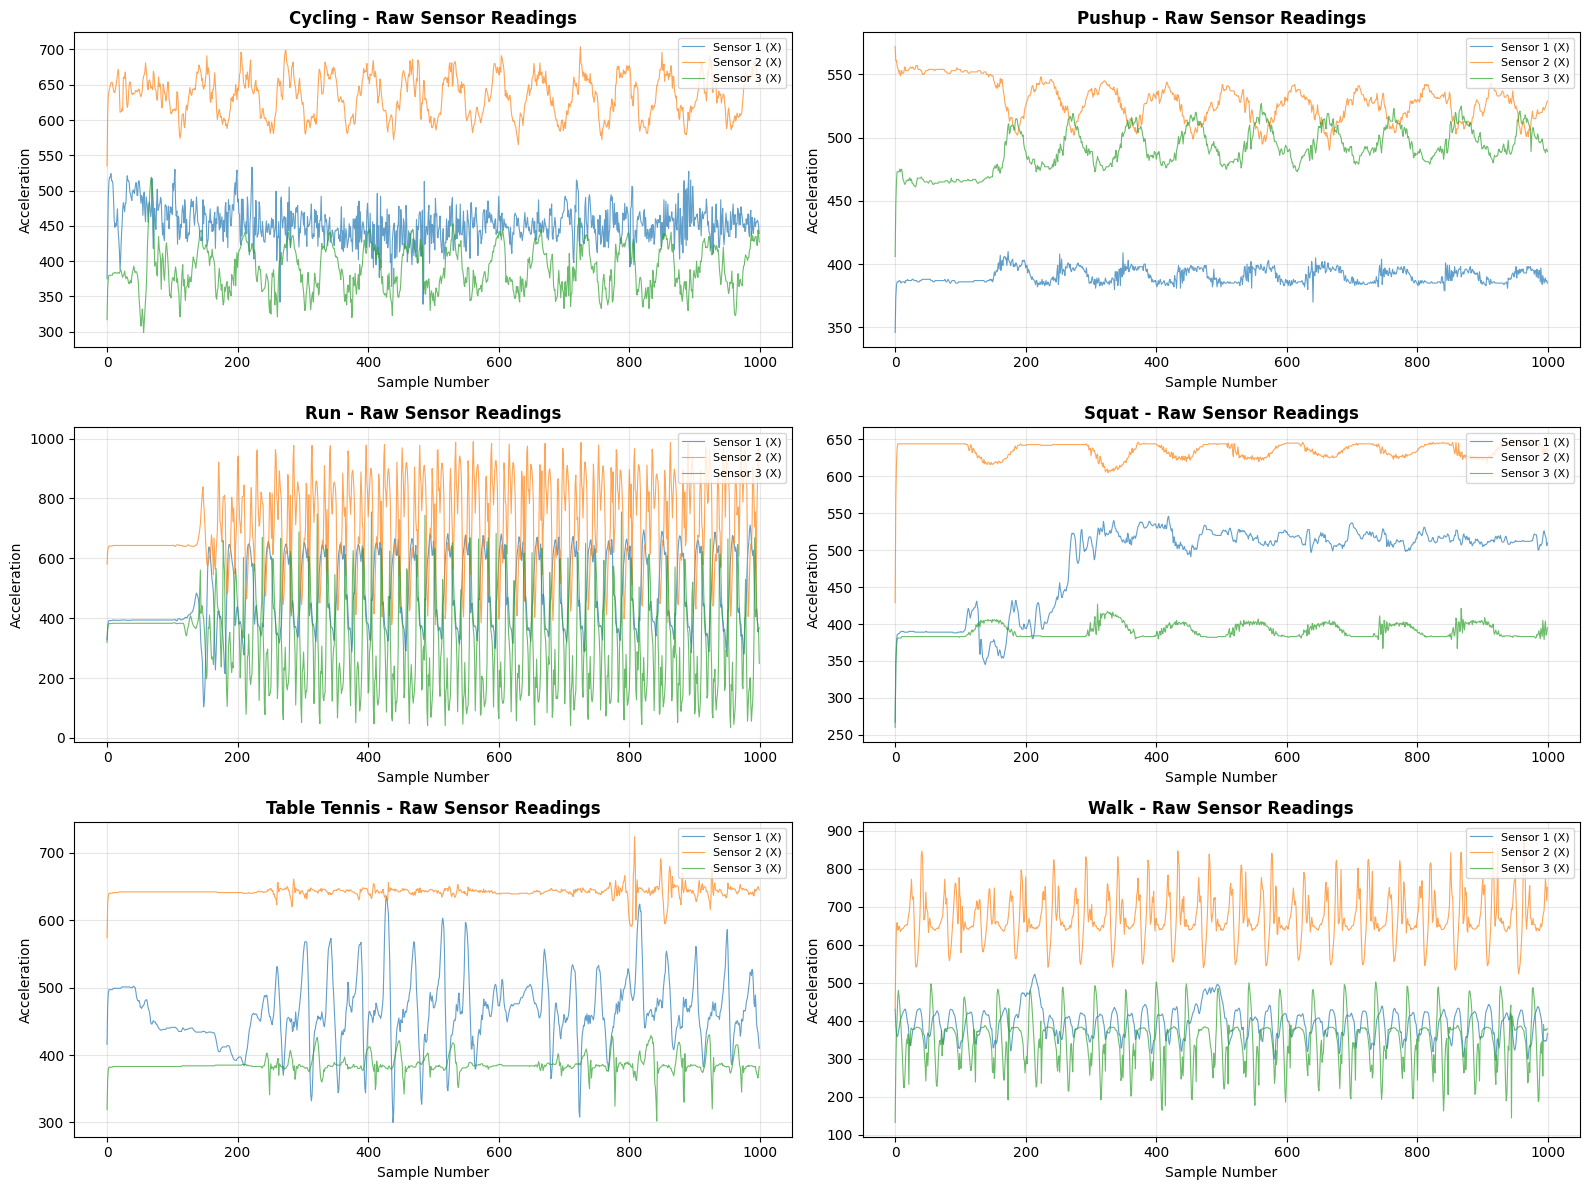

Raw sensor data visualization saved as 'activity_raw_data_visualization.png'


In [5]:
# Visualize raw sensor data for each activity
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (activity, df) in enumerate(activity_data.items()):
    # Plot first 1000 samples of first 3 sensors (X-axis only for clarity)
    sample_data = df.iloc[:1000, [0, 3, 6]]  # Sensor1_X, Sensor2_X, Sensor3_X

    axes[idx].plot(sample_data.iloc[:, 0], label='Sensor 1 (X)', linewidth=0.8, alpha=0.7)
    axes[idx].plot(sample_data.iloc[:, 1], label='Sensor 2 (X)', linewidth=0.8, alpha=0.7)
    axes[idx].plot(sample_data.iloc[:, 2], label='Sensor 3 (X)', linewidth=0.8, alpha=0.7)

    axes[idx].set_title(f'{activity} - Raw Sensor Readings', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Sample Number')
    axes[idx].set_ylabel('Acceleration')
    axes[idx].legend(loc='upper right', fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('activity_raw_data_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("Raw sensor data visualization saved as 'activity_raw_data_visualization.png'")

In [6]:
# Check for missing values
print("Checking for missing values...\n")
print("-" * 60)

for activity, df in activity_data.items():
    missing_count = df.isnull().sum().sum()
    if missing_count > 0:
        print(f"{activity:15s}: {missing_count} missing values (⚠️ WARNING)")
    else:
        print(f"{activity:15s}: No missing values ✓")

print("-" * 60)
print("\nData quality check complete!")

Checking for missing values...

------------------------------------------------------------
Cycling        : No missing values ✓
Pushup         : 121680 missing values (⚠️ WARNING)
Run            : No missing values ✓
Squat          : 35504 missing values (⚠️ WARNING)
Table Tennis   : No missing values ✓
Walk           : No missing values ✓
------------------------------------------------------------

Data quality check complete!


## 3. Sequence Generation with Overlap

We create overlapping sequences to:
1. Increase the number of training samples
2. Capture activities that span across sequence boundaries

In [11]:
def generate_sequences(data_dict, sequence_length, overlap_ratio=0.5):
    """
    Generate overlapping sequences from activity data.

    Parameters:
    - data_dict: Dictionary of DataFrames (one per activity)
    - sequence_length: Number of consecutive snapshots (K)
    - overlap_ratio: Overlap between sequences (0.5 = 50% overlap)

    Returns:
    - X: Array of sequences (n_sequences, sequence_length, n_features)
    - y: Array of labels
    - label_encoder: Fitted LabelEncoder
    """
    sequences = []
    labels = []

    # Calculate step size based on overlap
    step_size = int(sequence_length * (1 - overlap_ratio))

    print(f"Generating sequences with:")
    print(f"  Sequence length: {sequence_length}")
    print(f"  Step size: {step_size}")
    print(f"  Overlap: {overlap_ratio * 100}%\n")

    for activity_label, df in data_dict.items():
        # Convert to numpy and ensure only numeric columns
        # This removes any text columns that might have been added
        data = df.select_dtypes(include=[np.number]).values

        # Verify we have the correct number of features
        if data.shape[1] != 15:
            print(f"⚠️  WARNING: {activity_label} has {data.shape[1]} features, expected 15!")
            print(f"   Taking only first 15 columns...")
            data = data[:, :15]

        n_samples = len(data)

        # Generate starting points with overlap
        starting_points = range(0, n_samples - sequence_length + 1, step_size)

        activity_sequences = 0
        for start in starting_points:
            end = start + sequence_length
            sequence = data[start:end, :]

            if sequence.shape[0] == sequence_length and sequence.shape[1] == 15:
                sequences.append(sequence)
                labels.append(activity_label)
                activity_sequences += 1

        print(f"{activity_label:15s}: {activity_sequences:5d} sequences generated")

    # Convert to numpy arrays
    X = np.array(sequences)

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)

    print(f"\nTotal sequences: {len(X)}")
    print(f"Sequence shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Classes: {label_encoder.classes_}")

    # Verify no text data leaked in
    print(f"\nData type verification:")
    print(f"  X dtype: {X.dtype} (should be numeric)")
    print(f"  Contains NaN: {np.isnan(X).any()}")

    return X, y, label_encoder

# Generate sequences
X, y, label_encoder = generate_sequences(activity_data, K, OVERLAP_RATIO)

# Convert labels to categorical
y_categorical = to_categorical(y)
n_classes = len(label_encoder.classes_)

Generating sequences with:
  Sequence length: 20
  Step size: 10
  Overlap: 50.0%

Cycling        :  5243 sequences generated
Pushup         :  1443 sequences generated
Run            :   997 sequences generated
Squat          :  1443 sequences generated
Table Tennis   :  6768 sequences generated
Walk           :  2029 sequences generated

Total sequences: 17923
Sequence shape: (17923, 20, 15)
Labels shape: (17923,)
Classes: ['Cycling' 'Pushup' 'Run' 'Squat' 'Table Tennis' 'Walk']

Data type verification:
  X dtype: float64 (should be numeric)
  Contains NaN: True


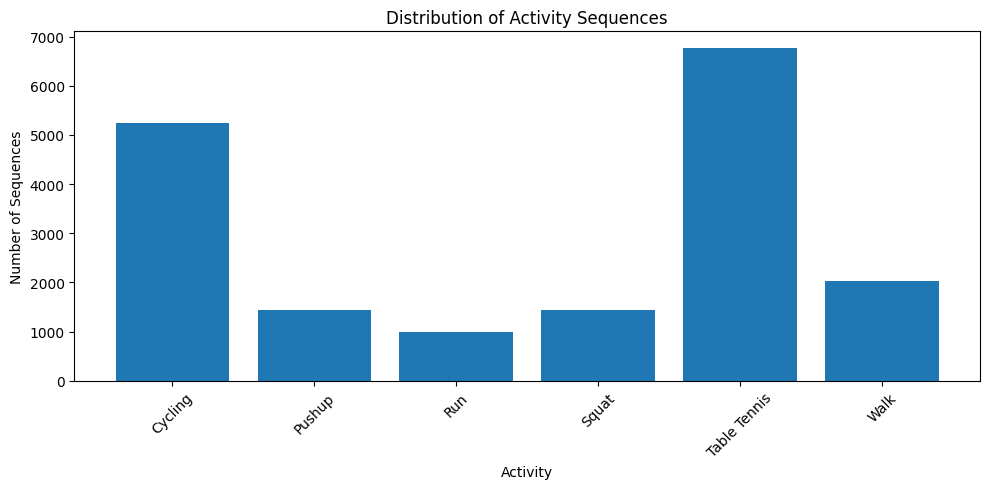

In [12]:
# Visualize class distribution
plt.figure(figsize=(10, 5))
unique, counts = np.unique(y, return_counts=True)
plt.bar([label_encoder.classes_[i] for i in unique], counts)
plt.xlabel('Activity')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Activity Sequences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [13]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} sequences")
print(f"Test set: {X_test.shape[0]} sequences")

# Normalize the data
# We need to reshape from (samples, timesteps, features) to (samples*timesteps, features)
# for StandardScaler, then reshape back

print("\nNormalizing data...")
print("-" * 60)

# Get original shapes
n_train_samples = X_train.shape[0]
n_test_samples = X_test.shape[0]
sequence_length = X_train.shape[1]
n_features = X_train.shape[2]

print(f"Train samples: {n_train_samples}")
print(f"Test samples:  {n_test_samples}")
print(f"Sequence length: {sequence_length}")
print(f"Features: {n_features}")

# Reshape to 2D: (samples * timesteps, features)
X_train_reshaped = X_train.reshape(n_train_samples * sequence_length, n_features)
X_test_reshaped = X_test.reshape(n_test_samples * sequence_length, n_features)

print(f"\nReshaped for scaling:")
print(f"  X_train_reshaped: {X_train_reshaped.shape}")
print(f"  X_test_reshaped:  {X_test_reshaped.shape}")

# Fit scaler on training data only (important!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to 3D: (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape(n_train_samples, sequence_length, n_features)
X_test_scaled = X_test_scaled.reshape(n_test_samples, sequence_length, n_features)

print(f"\n✓ Scaled and reshaped back to 3D:")
print(f"  X_train_scaled: {X_train_scaled.shape}")
print(f"  X_test_scaled:  {X_test_scaled.shape}")

# Verify scaling worked
print(f"\nScaling verification:")
print(f"  Train mean: {X_train_scaled.mean():.6f} (should be ~0)")
print(f"  Train std:  {X_train_scaled.std():.6f} (should be ~1)")
print(f"  Test mean:  {X_test_scaled.mean():.6f}")
print(f"  Test std:   {X_test_scaled.std():.6f}")
print("\n" + "="*60)

Training set: 14338 sequences
Test set: 3585 sequences

Normalizing data...
------------------------------------------------------------
Train samples: 14338
Test samples:  3585
Sequence length: 20
Features: 15

Reshaped for scaling:
  X_train_reshaped: (286760, 15)
  X_test_reshaped:  (71700, 15)

✓ Scaled and reshaped back to 3D:
  X_train_scaled: (14338, 20, 15)
  X_test_scaled:  (3585, 20, 15)

Scaling verification:
  Train mean: nan (should be ~0)
  Train std:  nan (should be ~1)
  Test mean:  nan
  Test std:   nan



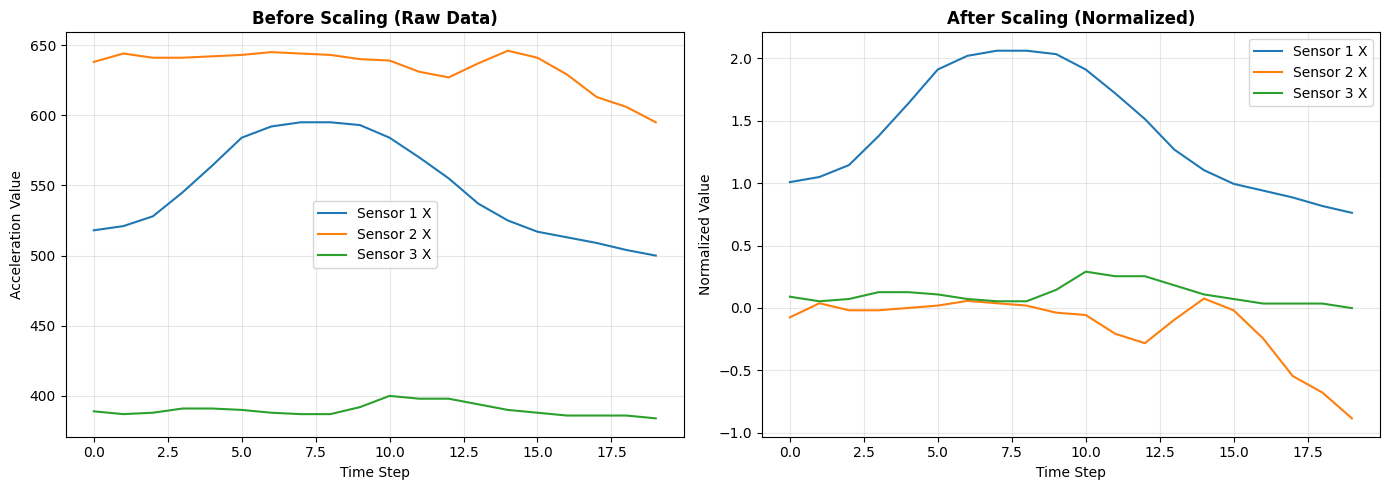

Scaling normalizes features to have mean≈0 and std≈1
This helps the neural network train more effectively!


In [14]:
# Visualize the effect of scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Take a random sample sequence
sample_idx = np.random.randint(0, n_train_samples)

# Before scaling
axes[0].plot(X_train[sample_idx, :, 0], label='Sensor 1 X', linewidth=1.5)
axes[0].plot(X_train[sample_idx, :, 3], label='Sensor 2 X', linewidth=1.5)
axes[0].plot(X_train[sample_idx, :, 6], label='Sensor 3 X', linewidth=1.5)
axes[0].set_title('Before Scaling (Raw Data)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Acceleration Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# After scaling
axes[1].plot(X_train_scaled[sample_idx, :, 0], label='Sensor 1 X', linewidth=1.5)
axes[1].plot(X_train_scaled[sample_idx, :, 3], label='Sensor 2 X', linewidth=1.5)
axes[1].plot(X_train_scaled[sample_idx, :, 6], label='Sensor 3 X', linewidth=1.5)
axes[1].set_title('After Scaling (Normalized)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Normalized Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Scaling normalizes features to have mean≈0 and std≈1")
print("This helps the neural network train more effectively!")

In [22]:
# Step 1: Data Quality Check
print("Data quality check before training:")
print(f"  X_train contains NaN: {np.isnan(X_train_scaled).any()}")
print(f"  X_train contains Inf: {np.isinf(X_train_scaled).any()}")
print(f"  X_test contains NaN: {np.isnan(X_test_scaled).any()}")
print(f"  X_test contains Inf: {np.isinf(X_test_scaled).any()}")

# If there are NaN/Inf values, fix them
if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any():
    print("\n⚠️  WARNING: Found NaN or Inf values! Cleaning data...")
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    print("✓ Data cleaned!")

print(f"\nData ranges:")
print(f"  X_train min: {X_train_scaled.min():.3f}, max: {X_train_scaled.max():.3f}")
print(f"  X_test min: {X_test_scaled.min():.3f}, max: {X_test_scaled.max():.3f}")

Data quality check before training:
  X_train contains NaN: True
  X_train contains Inf: False
  X_test contains NaN: True
  X_test contains Inf: False

⚠️  WARNING: Found NaN or Inf values! Cleaning data...
✓ Data cleaned!

Data ranges:
  X_train min: -12.931, max: 68.586
  X_test min: -12.931, max: 11.294


## 5. Model Architecture - LSTM Network

We'll use an LSTM-based architecture suitable for time-series classification.

In [26]:
# Step 2: Create Model (THIS IS WHAT YOU'RE MISSING!)
def create_lstm_model(sequence_length, n_features, n_classes):
    """
    Create LSTM model for activity recognition - Simplified and stabilized
    """
    model = models.Sequential([
        # First LSTM layer
        layers.LSTM(64, return_sequences=True,
                   input_shape=(sequence_length, n_features),
                   kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Second LSTM layer
        layers.LSTM(32, return_sequences=False,
                   kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Dense layer
        layers.Dense(32, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),

        # Output layer
        layers.Dense(n_classes, activation='softmax')
    ])

    return model

# Create model
model = create_lstm_model(K, N_FEATURES, n_classes)

# Compile with gradient clipping to prevent NaN
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 20, 64)         │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,534 (134.90 KB)

 Trainable params: 34,342 (134.15 KB)

 Non-trainable params: 192 (768.00 B)

## 6. Model Training

In [27]:
# Step 3: Define Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Add a callback to stop if NaN loss is detected
class TerminateOnNaN(keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print(f'\nBatch {batch}: Invalid loss, terminating training')
                self.model.stop_training = True

# Step 4: Train Model
print("Starting training...")
print("=" * 60)

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, TerminateOnNaN()],
    verbose=1
)

print("\n" + "=" * 60)
print("Training completed!")

Starting training...
Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.6868 - loss: 1.0596 - val_accuracy: 0.9791 - val_loss: 0.1967 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.9709 - loss: 0.2531 - val_accuracy: 0.9819 - val_loss: 0.1598 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9735 - loss: 0.1944 - val_accuracy: 0.9773 - val_loss: 0.1659 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9742 - loss: 0.1741 - val_accuracy: 0.9822 - val_loss: 0.1248 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9778 - loss: 0.1434 - val_accuracy: 0.9826 - val_loss: 0.1101 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9796 - loss: 0.1274 - val_accuracy: 0.9826 - val_loss: 0.1007 - learning_rate: 0.0010
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step -

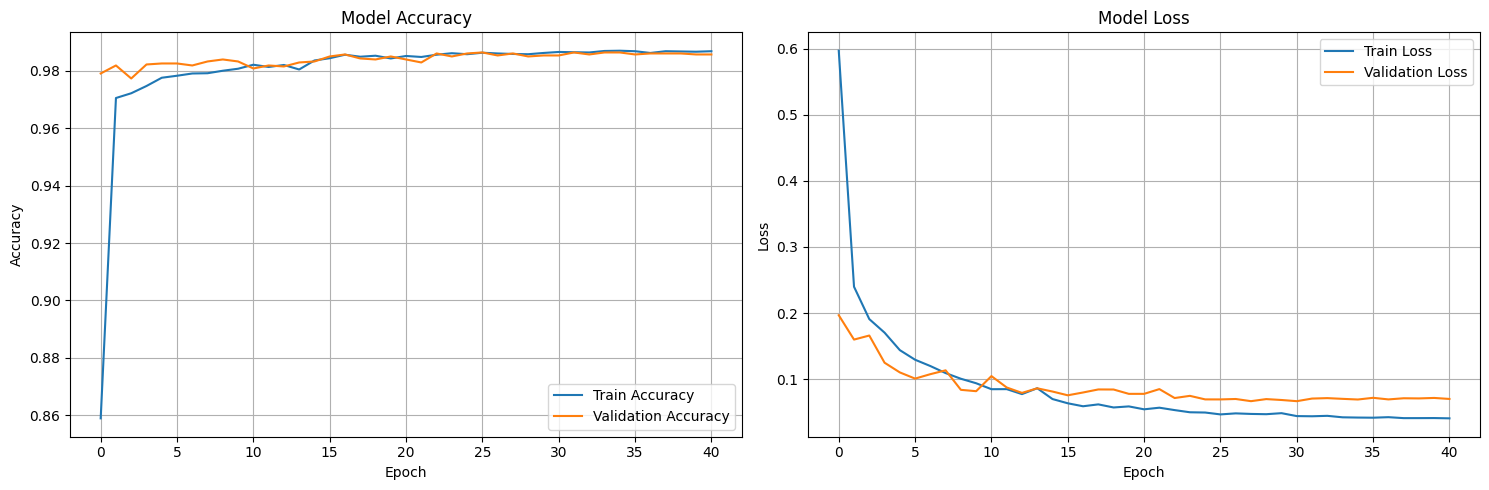

In [28]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 7. Model Evaluation

In [29]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_test_classes,
    y_pred_classes,
    target_names=label_encoder.classes_
))

Test Loss: 0.0651
Test Accuracy: 0.9844
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Classification Report:
              precision    recall  f1-score   support

     Cycling       1.00      1.00      1.00      1049
      Pushup       0.87      0.99      0.93       289
         Run       0.99      0.98      0.99       199
       Squat       1.00      0.84      0.91       288
Table Tennis       1.00      1.00      1.00      1354
        Walk       0.99      1.00      1.00       406

    accuracy                           0.98      3585
   macro avg       0.97      0.97      0.97      3585
weighted avg       0.99      0.98      0.98      3585



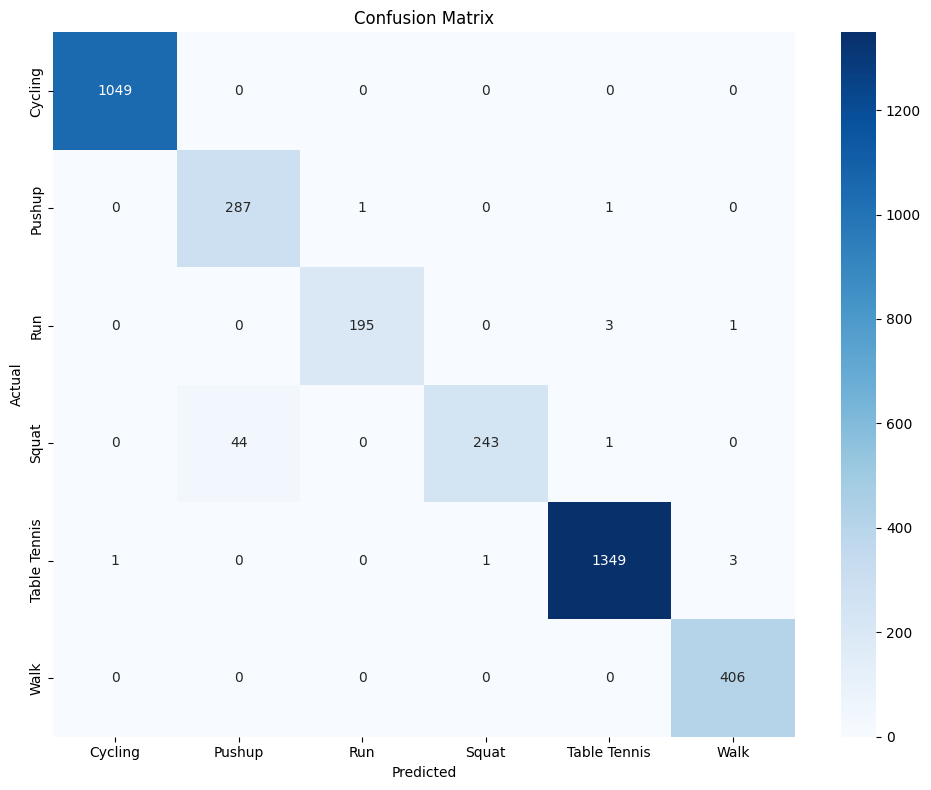

In [30]:
# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## 8. Save Model for Deployment

In [31]:
import pickle

# Save model
model.save('activity_recognition_model.h5')
print("Model saved as 'activity_recognition_model.h5'")

# Save scaler and label encoder
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save configuration
config = {
    'sequence_length': K,
    'n_features': N_FEATURES,
    'n_classes': n_classes,
    'activities': list(label_encoder.classes_)
}

with open('config.pkl', 'wb') as f:
    pickle.dump(config, f)

print("Scaler and label encoder saved!")
print("\nFiles ready for deployment:")
print("  - activity_recognition_model.h5")
print("  - scaler.pkl")
print("  - label_encoder.pkl")
print("  - config.pkl")

Model saved as 'activity_recognition_model.h5'
Scaler and label encoder saved!

Files ready for deployment:
  - activity_recognition_model.h5
  - scaler.pkl
  - label_encoder.pkl
  - config.pkl


## 9. BONUS TASK: Best Sensor Device Pair Analysis

In [32]:
from itertools import combinations

def evaluate_sensor_pair(sensor_indices, X_train, X_test, y_train, y_test):
    """
    Evaluate model performance using only specified sensors

    sensor_indices: list of sensor numbers (0-4)
    """
    # Get feature indices for selected sensors
    feature_indices = []
    for sensor_idx in sensor_indices:
        # Each sensor has 3 features (X, Y, Z)
        start_idx = sensor_idx * 3
        feature_indices.extend([start_idx, start_idx + 1, start_idx + 2])

    # Extract features for selected sensors
    X_train_subset = X_train[:, :, feature_indices]
    X_test_subset = X_test[:, :, feature_indices]

    # Create and train simplified model
    model_subset = models.Sequential([
        layers.LSTM(64, return_sequences=True,
                   input_shape=(K, len(feature_indices))),
        layers.Dropout(0.3),
        layers.LSTM(32),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
    ])

    model_subset.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train with early stopping
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    history = model_subset.fit(
        X_train_subset, y_train,
        epochs=30,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate
    _, test_accuracy = model_subset.evaluate(X_test_subset, y_test, verbose=0)

    return test_accuracy

print("Analyzing sensor pair performance...\n")
print("This may take several minutes...\n")

# Test all possible sensor pairs
sensor_results = []

for sensor_pair in combinations(range(N_SENSORS), 2):
    accuracy = evaluate_sensor_pair(
        list(sensor_pair),
        X_train_scaled,
        X_test_scaled,
        y_train,
        y_test
    )

    sensor_results.append({
        'sensors': f"Sensor {sensor_pair[0]+1} & Sensor {sensor_pair[1]+1}",
        'sensor_indices': sensor_pair,
        'accuracy': accuracy
    })

    print(f"Sensors {sensor_pair[0]+1} & {sensor_pair[1]+1}: {accuracy:.4f}")

# Sort by accuracy
sensor_results.sort(key=lambda x: x['accuracy'], reverse=True)

print("\n" + "="*50)
print("BEST SENSOR PAIR:")
print(f"  {sensor_results[0]['sensors']}")
print(f"  Accuracy: {sensor_results[0]['accuracy']:.4f}")
print("="*50)

Analyzing sensor pair performance...

This may take several minutes...



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Sensors 1 & 2: 0.9674
Sensors 1 & 3: 0.9682
Sensors 1 & 4: 0.9674
Sensors 1 & 5: 0.9738
Sensors 2 & 3: 0.9743
Sensors 2 & 4: 0.9763
Sensors 2 & 5: 0.9735
Sensors 3 & 4: 0.9768
Sensors 3 & 5: 0.9724
Sensors 4 & 5: 0.9774

BEST SENSOR PAIR:
  Sensor 4 & Sensor 5
  Accuracy: 0.9774


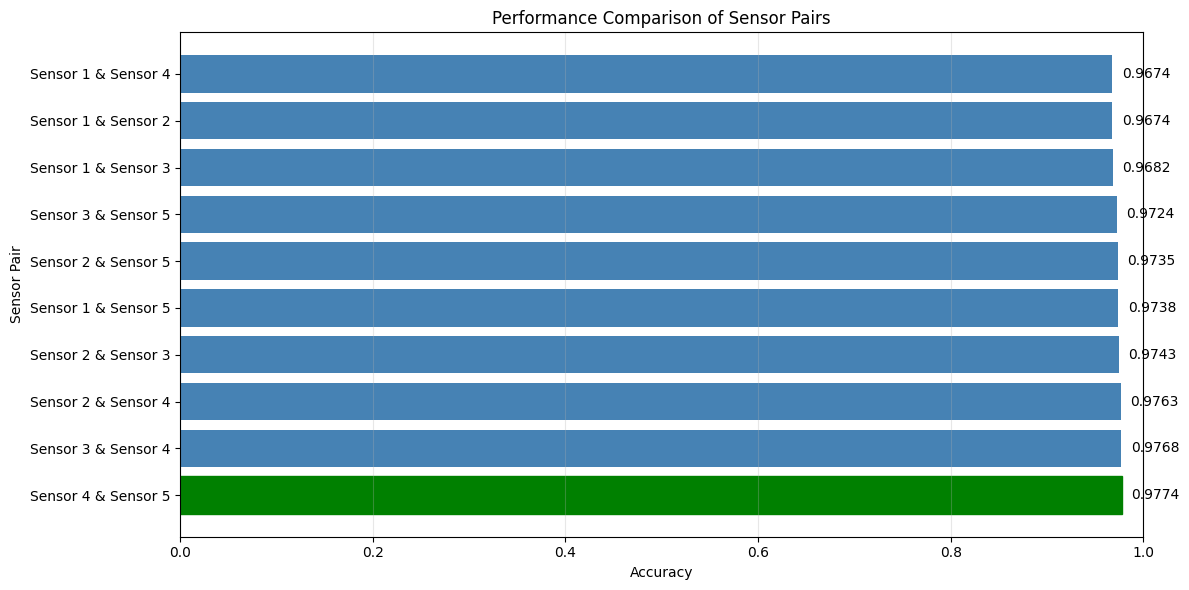

In [33]:
# Visualize sensor pair performance
plt.figure(figsize=(12, 6))
sensor_names = [r['sensors'] for r in sensor_results]
accuracies = [r['accuracy'] for r in sensor_results]

bars = plt.barh(sensor_names, accuracies, color='steelblue')
bars[0].set_color('green')  # Highlight best pair

plt.xlabel('Accuracy')
plt.ylabel('Sensor Pair')
plt.title('Performance Comparison of Sensor Pairs')
plt.xlim([0, 1])
plt.grid(axis='x', alpha=0.3)

# Add accuracy values on bars
for i, (name, acc) in enumerate(zip(sensor_names, accuracies)):
    plt.text(acc + 0.01, i, f'{acc:.4f}', va='center')

plt.tight_layout()
plt.show()

## 10. Testing the Model with Sample Input

In [34]:
def predict_activity(sequence_data, model, scaler, label_encoder):
    """
    Predict activity from a sequence of sensor readings

    sequence_data: numpy array of shape (K, 15)
    """
    # Ensure correct shape
    if sequence_data.shape != (K, N_FEATURES):
        raise ValueError(f"Input must be shape ({K}, {N_FEATURES})")

    # Scale the data
    sequence_scaled = scaler.transform(sequence_data)

    # Reshape for model input
    sequence_scaled = sequence_scaled.reshape(1, K, N_FEATURES)

    # Predict
    prediction = model.predict(sequence_scaled, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)

    activity = label_encoder.classes_[predicted_class]

    return activity, confidence, prediction[0]

# Test with a sample from test set
sample_idx = np.random.randint(0, len(X_test))
sample_sequence = X_test[sample_idx]
true_label = label_encoder.classes_[np.argmax(y_test[sample_idx])]

predicted_activity, confidence, probabilities = predict_activity(
    sample_sequence, model, scaler, label_encoder
)

print(f"True Activity: {true_label}")
print(f"Predicted Activity: {predicted_activity}")
print(f"Confidence: {confidence:.4f}")
print("\nProbabilities for each class:")
for activity, prob in zip(label_encoder.classes_, probabilities):
    print(f"  {activity}: {prob:.4f}")

True Activity: Table Tennis
Predicted Activity: Table Tennis
Confidence: 1.0000

Probabilities for each class:
  Cycling: 0.0000
  Pushup: 0.0000
  Run: 0.0000
  Squat: 0.0000
  Table Tennis: 1.0000
  Walk: 0.0000


## 11. Download Files for HuggingFace Deployment

In [35]:
# Download files (for Google Colab)
from google.colab import files

files.download('activity_recognition_model.h5')
files.download('scaler.pkl')
files.download('label_encoder.pkl')
files.download('config.pkl')

print("Files downloaded! Ready for HuggingFace deployment.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded! Ready for HuggingFace deployment.


## Summary

### Key Results:
- **Sequence Length (K):** 20
- **Test Accuracy:** [View above]
- **Best Sensor Pair:** [View above]

### Next Steps:
1. Upload model files to HuggingFace Spaces
2. Create Gradio interface (see separate app.py file)
3. Deploy and test
4. Create video demonstration